In [259]:
import gym
import numpy as np
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random

from itertools import count
from collections import namedtuple


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Replay Buffer of Transition 

In [306]:
Transition = namedtuple('Transition', 
                       ('state', 'action', 'next_state', 'reward'))

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
    
    def push(self, *args):
        if len(self.memory) == self.capacity:
            self.memory.pop()
        
        self.memory.insert(0, Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size) # a list of element from self.memory
    
    def __len__(self):
        return len(self.memory)

# Critic - Q Function

In [307]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        '''
        2 Hidden layers
        400 & 300 units each
        action is only introduced in 2nd hidden layer
        '''
        super(Critic, self).__init__()
        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400 + action_dim, 300)
        self.l3 = nn.Linear(300, 1)
        
    def forward(self, state, action):
        x = F.relu(self.l1(state))
        x = F.relu(self.l2(torch.cat([x, action], dim=1)))
        x = self.l3(x)
        return x

# Actor - Policy

In [308]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, sup_action):
        super(Actor, self).__init__()
        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)
        self.sup_action = sup_action  # suppermum of action space
    
    def forward(self, state):
        x = F.relu(self.l1(state))
        x = F.relu(self.l2(x))
        x = self.sup_action * torch.tanh(self.l3(x))
        return x

# DDPG (mainly everything)

In [309]:
class DDPG(object):
    def __init__(self, state_dim, action_dim, sup_action, memory_capacity, batch_size, 
                 gamma=0.99, critic_lr=1e-2, actor_lr=1e-3, polyak=0.999):
        # critic
        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
        
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())

        # actor
        self.actor = Actor(state_dim, action_dim, sup_action).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        
        self.actor_target = Actor(state_dim, action_dim, sup_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        
        # replay buffer
        self.replay_buffer = ReplayBuffer(memory_capacity)
        # hyper parameters
        self.BATCH_SIZE = batch_size
        self.GAMMA = gamma
        self.polyak = polyak
    
    def train(self, iteration):
        avg_critic_loss = 0
        avg_actor_loss = 0
        for i in range(iteration):
            # sample exp from replay buffer
            transitions = self.replay_buffer.sample(self.BATCH_SIZE)
            batch = Transition(*zip(*transitions))
            # pull out index (i.e. mask) in the batch & next_state of transitions having next_state is not None
            mask_nonFinal_next_states = torch.tensor(tuple(map(lambda s: s is not None, 
                                                              batch.next_state)), device=device, dtype=torch.uint8)
            nonFinal_next_states = torch.cat([s for s in batch.next_state
                                                 if s is not None])
            # construct tensor of state, action, reward
            states_batch = torch.cat(batch.state)
            actions_batch = torch.cat(batch.action)
            reward_batch = torch.cat(batch.reward)

            # compute TD target
            next_state_act_val = torch.zeros([self.BATCH_SIZE, 1], device=device)
    #         print(self.actor_target(nonFinal_next_states))
    #         print("nonFinal_next_states:\n", nonFinal_next_states)
    #         print("critic output:\n",self.critic_target(nonFinal_next_states, 
    #                                                                         self.actor_target(nonFinal_next_states)))
    #         print("mask_nonFinal_next_states:\n", mask_nonFinal_next_states)
            next_state_act_val[mask_nonFinal_next_states] = self.critic_target(nonFinal_next_states, 
                                                                            self.actor_target(nonFinal_next_states))
            td_target = reward_batch + self.GAMMA * next_state_act_val

            critic_loss = F.mse_loss(self.critic(states_batch, actions_batch), td_target)  # MS of td_error
            avg_critic_loss += critic_loss.item()
            
            # call optimizer of critic to minimize loss
            self.critic_optimizer.zero_grad()
            critic_loss.backward(retain_graph=True)
            self.critic_optimizer.step()

            # Update actor
            actor_loss = -self.critic(states_batch, self.actor(states_batch)).mean() 
            avg_actor_loss += actor_loss
            
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Update target actor & target critic
            with torch.no_grad():
                for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                    target_param.data.copy_((1 - self.polyak) * param.data + self.polyak * target_param.data)

                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_((1 - self.polyak) * param.data + self.polyak * target_param.data)
            
            return avg_critic_loss/iteration, avg_actor_loss/iteration
    
    def select_action(self, state):
#         state = torch.FloatTensor(state.reshape(1, -1)).to(device)
#         return self.actor(state).cpu().data.numpy().flatten()
        return self.actor(state)


# Utilities

In [310]:
def to_tensor(np_array):
    '''
    convert 1d np array to tensor (written as a row vector)
    '''
    return torch.FloatTensor(np_array.reshape(1, -1)).to(device)

def checkout_actor(render=False):
    state = env.reset()
    state = to_tensor(state)
    accu_reward = 0
    for step in count():
        action = agent.actor(state)
        
        _act = action.cpu()
        next_state, reward, done, _ = env.step(_act.data.numpy().flatten())
        accu_reward += reward
        next_state = to_tensor(next_state)
        
        if render:
            env.render()
        if done:
            print("Episode %d [ACTOR] Finish after %d step" % (i_episode, step+1))
            print("-------------------------------------")
            break
        # Move on 
        state.data.copy_(next_state.data)
    return accu_reward

# checkout_actor()
# time.sleep(1)
# env.close()

# Training

In [315]:
env = gym.make("LunarLanderContinuous-v2")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
sup_action = torch.Tensor(env.action_space.high).to(device)

memory_capacity = 10000
batch_size = 64

agent = DDPG(state_dim, action_dim, sup_action, memory_capacity, batch_size)

actor_accumulated_reward = []

In [319]:
max_episode = 501
max_random_action_steps = 0#1000
random_action_steps = 0

flag_collecting_exp = 0

for i_episode in range(max_episode):
    state = env.reset()
    state = to_tensor(state)
    for step in count():
        # Choose action
        if random_action_steps < max_random_action_steps:
            action = to_tensor(env.action_space.sample())
            random_action_steps += 1
        else:
            action = agent.select_action(state)    
        
        # take action & observe next state & reward
        _act = action.cpu()
        _act = (_act.data.numpy().flatten() + np.random.normal(0, 20., size=action_dim)).clip(env.action_space.low, 
                                                                                             env.action_space.high)
        next_state, reward, done, _ = env.step(_act)
        next_state = to_tensor(next_state)
        reward = to_tensor(np.array([reward]))
        
        # update replay buffer
        action = to_tensor(_act)
        agent.replay_buffer.push(state, action, next_state, reward)
        
        # check if replay_buffer is enough for update
        if agent.replay_buffer.__len__() < max_random_action_steps:
            if flag_collecting_exp == 0:
                flag_collecting_exp = 1
                print("Collecting experience ...")
            continue
        
        if flag_collecting_exp == 1:
            flag_collecting_exp = 2
            print("Done collecting exp >>> Enter training process")
        
        # if enough experiences for update
        avg_critic_loss, avg_actor_loss = agent.train(iteration=5)
        if step % 100 == 0:
            print("Episode %d \t critic loss: %.3f \t actor loss:%.3f" % (i_episode, avg_critic_loss, 
                                                                          avg_actor_loss))
        
        if done:
            _rew = reward.cpu()
            print("Episode %d finish with reward = %.2f" % (i_episode, _rew.data.numpy().flatten()))
            print("------------------------------------------------")
            break
        
        # move on
        state.data.copy_(next_state.data)
    
    if i_episode % 10 == 0:
        actor_accumulated_reward.append(checkout_actor())
        

Episode 0 	 critic loss: 3.335 	 actor loss:5.828
Episode 0 finish with reward = -100.00
------------------------------------------------
Episode 0 [ACTOR] Finish after 68 step
-------------------------------------
Episode 1 	 critic loss: 2.838 	 actor loss:5.917
Episode 1 	 critic loss: 2.035 	 actor loss:5.709
Episode 1 finish with reward = -100.00
------------------------------------------------
Episode 2 	 critic loss: 3.484 	 actor loss:5.752
Episode 2 	 critic loss: 1.299 	 actor loss:5.636
Episode 2 finish with reward = -100.00
------------------------------------------------
Episode 3 	 critic loss: 1.530 	 actor loss:5.719
Episode 3 	 critic loss: 34.606 	 actor loss:5.692
Episode 3 finish with reward = -100.00
------------------------------------------------
Episode 4 	 critic loss: 63.860 	 actor loss:5.877
Episode 4 	 critic loss: 4.199 	 actor loss:5.837
Episode 4 finish with reward = -100.00
------------------------------------------------
Episode 5 	 critic loss: 3.646 

Episode 45 finish with reward = -100.00
------------------------------------------------
Episode 46 	 critic loss: 5.803 	 actor loss:5.624
Episode 46 	 critic loss: 6.077 	 actor loss:5.632
Episode 46 finish with reward = -100.00
------------------------------------------------
Episode 47 	 critic loss: 6.253 	 actor loss:5.877
Episode 47 finish with reward = -100.00
------------------------------------------------
Episode 48 	 critic loss: 36.139 	 actor loss:5.646
Episode 48 finish with reward = -100.00
------------------------------------------------
Episode 49 	 critic loss: 56.060 	 actor loss:5.438
Episode 49 finish with reward = -100.00
------------------------------------------------
Episode 50 	 critic loss: 36.306 	 actor loss:5.720
Episode 50 finish with reward = -100.00
------------------------------------------------
Episode 50 [ACTOR] Finish after 52 step
-------------------------------------
Episode 51 	 critic loss: 5.232 	 actor loss:5.391
Episode 51 	 critic loss: 5.

Episode 91 finish with reward = -100.00
------------------------------------------------
Episode 92 	 critic loss: 2.230 	 actor loss:4.787
Episode 92 finish with reward = -100.00
------------------------------------------------
Episode 93 	 critic loss: 31.232 	 actor loss:4.938
Episode 93 	 critic loss: 71.885 	 actor loss:4.887
Episode 93 finish with reward = -100.00
------------------------------------------------
Episode 94 	 critic loss: 3.325 	 actor loss:4.912
Episode 94 finish with reward = -100.00
------------------------------------------------
Episode 95 	 critic loss: 2.035 	 actor loss:4.692
Episode 95 finish with reward = -100.00
------------------------------------------------
Episode 96 	 critic loss: 2.391 	 actor loss:5.098
Episode 96 finish with reward = -100.00
------------------------------------------------
Episode 97 	 critic loss: 5.446 	 actor loss:4.880
Episode 97 	 critic loss: 36.102 	 actor loss:4.933
Episode 97 finish with reward = -100.00
---------------

Episode 139 finish with reward = -100.00
------------------------------------------------
Episode 140 	 critic loss: 59.616 	 actor loss:5.168
Episode 140 finish with reward = -100.00
------------------------------------------------
Episode 140 [ACTOR] Finish after 80 step
-------------------------------------
Episode 141 	 critic loss: 1.723 	 actor loss:5.157
Episode 141 	 critic loss: 2.338 	 actor loss:5.124
Episode 141 finish with reward = -100.00
------------------------------------------------
Episode 142 	 critic loss: 34.791 	 actor loss:5.051
Episode 142 	 critic loss: 32.134 	 actor loss:5.359
Episode 142 finish with reward = -100.00
------------------------------------------------
Episode 143 	 critic loss: 2.577 	 actor loss:5.354
Episode 143 finish with reward = -100.00
------------------------------------------------
Episode 144 	 critic loss: 2.576 	 actor loss:5.249
Episode 144 	 critic loss: 3.090 	 actor loss:5.220
Episode 144 finish with reward = -100.00
-----------

Episode 184 	 critic loss: 34.326 	 actor loss:5.987
Episode 184 finish with reward = -100.00
------------------------------------------------
Episode 185 	 critic loss: 2.325 	 actor loss:5.820
Episode 185 	 critic loss: 2.363 	 actor loss:6.052
Episode 185 finish with reward = -100.00
------------------------------------------------
Episode 186 	 critic loss: 3.261 	 actor loss:6.109
Episode 186 finish with reward = -100.00
------------------------------------------------
Episode 187 	 critic loss: 4.597 	 actor loss:6.089
Episode 187 finish with reward = -100.00
------------------------------------------------
Episode 188 	 critic loss: 94.725 	 actor loss:6.215
Episode 188 	 critic loss: 3.359 	 actor loss:6.091
Episode 188 finish with reward = -100.00
------------------------------------------------
Episode 189 	 critic loss: 3.511 	 actor loss:6.346
Episode 189 	 critic loss: 36.741 	 actor loss:6.049
Episode 189 finish with reward = -100.00
--------------------------------------

Episode 230 	 critic loss: 3.212 	 actor loss:7.310
Episode 230 finish with reward = -100.00
------------------------------------------------
Episode 230 [ACTOR] Finish after 62 step
-------------------------------------
Episode 231 	 critic loss: 32.358 	 actor loss:7.410
Episode 231 finish with reward = -100.00
------------------------------------------------
Episode 232 	 critic loss: 3.853 	 actor loss:7.604
Episode 232 	 critic loss: 37.931 	 actor loss:7.538
Episode 232 finish with reward = -100.00
------------------------------------------------
Episode 233 	 critic loss: 5.301 	 actor loss:7.753
Episode 233 finish with reward = -100.00
------------------------------------------------
Episode 234 	 critic loss: 3.046 	 actor loss:7.308
Episode 234 	 critic loss: 2.634 	 actor loss:7.434
Episode 234 finish with reward = -100.00
------------------------------------------------
Episode 235 	 critic loss: 32.766 	 actor loss:7.661
Episode 235 	 critic loss: 2.754 	 actor loss:7.476


Episode 275 finish with reward = -100.00
------------------------------------------------
Episode 276 	 critic loss: 3.377 	 actor loss:7.634
Episode 276 	 critic loss: 3.161 	 actor loss:7.321
Episode 276 finish with reward = -100.00
------------------------------------------------
Episode 277 	 critic loss: 63.997 	 actor loss:7.667
Episode 277 	 critic loss: 3.946 	 actor loss:7.453
Episode 277 finish with reward = -100.00
------------------------------------------------
Episode 278 	 critic loss: 26.910 	 actor loss:7.297
Episode 278 finish with reward = -100.00
------------------------------------------------
Episode 279 	 critic loss: 31.707 	 actor loss:7.528
Episode 279 finish with reward = -100.00
------------------------------------------------
Episode 280 	 critic loss: 3.919 	 actor loss:7.490
Episode 280 	 critic loss: 30.720 	 actor loss:7.345
Episode 280 finish with reward = -100.00
------------------------------------------------
Episode 280 [ACTOR] Finish after 54 step

Episode 320 	 critic loss: 8.334 	 actor loss:6.311
Episode 320 finish with reward = -100.00
------------------------------------------------
Episode 320 [ACTOR] Finish after 77 step
-------------------------------------
Episode 321 	 critic loss: 6.403 	 actor loss:6.824
Episode 321 finish with reward = -100.00
------------------------------------------------
Episode 322 	 critic loss: 67.528 	 actor loss:6.340
Episode 322 finish with reward = -100.00
------------------------------------------------
Episode 323 	 critic loss: 5.155 	 actor loss:6.431
Episode 323 	 critic loss: 6.375 	 actor loss:6.615
Episode 323 finish with reward = -100.00
------------------------------------------------
Episode 324 	 critic loss: 4.977 	 actor loss:6.706
Episode 324 	 critic loss: 39.413 	 actor loss:6.179
Episode 324 finish with reward = -100.00
------------------------------------------------
Episode 325 	 critic loss: 8.079 	 actor loss:6.354
Episode 325 finish with reward = -100.00
------------

Episode 362 	 critic loss: 33.657 	 actor loss:5.689
Episode 362 	 critic loss: 4.901 	 actor loss:5.619
Episode 362 finish with reward = -100.00
------------------------------------------------
Episode 363 	 critic loss: 35.590 	 actor loss:5.597
Episode 363 finish with reward = -100.00
------------------------------------------------
Episode 364 	 critic loss: 35.561 	 actor loss:5.244
Episode 364 	 critic loss: 34.984 	 actor loss:5.224
Episode 364 finish with reward = -100.00
------------------------------------------------
Episode 365 	 critic loss: 4.531 	 actor loss:5.440
Episode 365 finish with reward = -100.00
------------------------------------------------
Episode 366 	 critic loss: 6.868 	 actor loss:5.452
Episode 366 	 critic loss: 5.043 	 actor loss:5.598
Episode 366 finish with reward = -100.00
------------------------------------------------
Episode 367 	 critic loss: 3.859 	 actor loss:5.556
Episode 367 	 critic loss: 4.947 	 actor loss:5.368
Episode 367 finish with re

Episode 409 finish with reward = -100.00
------------------------------------------------
Episode 410 	 critic loss: 61.037 	 actor loss:5.164
Episode 410 finish with reward = -100.00
------------------------------------------------
Episode 410 [ACTOR] Finish after 82 step
-------------------------------------
Episode 411 	 critic loss: 2.546 	 actor loss:5.184
Episode 411 finish with reward = -100.00
------------------------------------------------
Episode 412 	 critic loss: 3.122 	 actor loss:5.218
Episode 412 finish with reward = -100.00
------------------------------------------------
Episode 413 	 critic loss: 4.414 	 actor loss:4.916
Episode 413 finish with reward = -100.00
------------------------------------------------
Episode 414 	 critic loss: 2.440 	 actor loss:5.119
Episode 414 	 critic loss: 3.870 	 actor loss:5.139
Episode 414 	 critic loss: 27.310 	 actor loss:5.084
Episode 414 finish with reward = -100.00
------------------------------------------------
Episode 415 	 c

Episode 455 	 critic loss: 2.282 	 actor loss:5.951
Episode 455 finish with reward = -100.00
------------------------------------------------
Episode 456 	 critic loss: 117.188 	 actor loss:5.971
Episode 456 	 critic loss: 41.556 	 actor loss:5.881
Episode 456 finish with reward = -100.00
------------------------------------------------
Episode 457 	 critic loss: 34.130 	 actor loss:5.810
Episode 457 	 critic loss: 4.667 	 actor loss:5.727
Episode 457 finish with reward = -100.00
------------------------------------------------
Episode 458 	 critic loss: 2.133 	 actor loss:5.641
Episode 458 	 critic loss: 2.142 	 actor loss:5.761
Episode 458 finish with reward = -100.00
------------------------------------------------
Episode 459 	 critic loss: 3.990 	 actor loss:6.013
Episode 459 finish with reward = -100.00
------------------------------------------------
Episode 460 	 critic loss: 4.341 	 actor loss:5.881
Episode 460 	 critic loss: 1.622 	 actor loss:5.937
Episode 460 finish with re

In [317]:
checkout_actor(True)

time.sleep(1)
env.close()

Episode 500 [ACTOR] Finish after 53 step
-------------------------------------


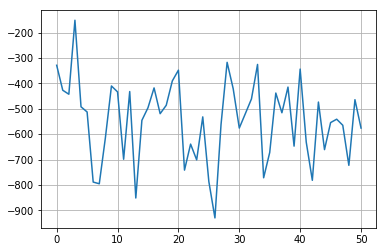

In [318]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(actor_accumulated_reward)
plt.grid()
plt.show()

In [29]:
transitions = agent.replay_buffer.sample(5)
batch = Transition(*zip(*transitions))
batch

Transition(state=(array([ 4.8494339e-04,  1.3986182e+00,  4.9104981e-02, -5.4674804e-01,
       -5.5514649e-04, -1.1123012e-02,  0.0000000e+00,  0.0000000e+00],
      dtype=float32), array([ 4.8494339e-04,  1.3986182e+00,  4.9104981e-02, -5.4674804e-01,
       -5.5514649e-04, -1.1123012e-02,  0.0000000e+00,  0.0000000e+00],
      dtype=float32), array([ 4.8494339e-04,  1.3986182e+00,  4.9104981e-02, -5.4674804e-01,
       -5.5514649e-04, -1.1123012e-02,  0.0000000e+00,  0.0000000e+00],
      dtype=float32), array([ 4.8494339e-04,  1.3986182e+00,  4.9104981e-02, -5.4674804e-01,
       -5.5514649e-04, -1.1123012e-02,  0.0000000e+00,  0.0000000e+00],
      dtype=float32), array([ 4.8494339e-04,  1.3986182e+00,  4.9104981e-02, -5.4674804e-01,
       -5.5514649e-04, -1.1123012e-02,  0.0000000e+00,  0.0000000e+00],
      dtype=float32)), action=(array([ 0.90190524, -0.5331595 ], dtype=float32), array([0.5834501 , 0.05778984], dtype=float32), array([-0.9756577, -0.3543409], dtype=float32), ar

In [37]:
_t = [torch.Tensor(s.reshape(1, -1)) for s in batch.next_state if s is not None]
_t

[tensor([[-2.9370e-03,  1.4113e-04,  9.1572e-03,  3.9177e-02,  2.3736e-03,
          -1.0942e-02,  1.0000e+00,  0.0000e+00]]),
 tensor([[ 0.0036,  1.3357,  0.0707, -0.5434, -0.0055, -0.0281,  0.0000,  0.0000]]),
 tensor([[-0.0128,  0.0067, -0.0076,  0.0027,  0.0027, -0.0463,  0.0000,  0.0000]]),
 tensor([[-1.2491e-02,  6.5849e-05, -5.3811e-03,  7.6920e-03,  8.6105e-04,
           6.2959e-03,  1.0000e+00,  1.0000e+00]]),
 tensor([[-2.7370e-05,  3.4030e-03, -2.1380e-02,  5.6296e-02,  3.6948e-02,
           1.8916e-01,  0.0000e+00,  1.0000e+00]])]

In [39]:
torch.cat(_t)

tensor([[-2.9370e-03,  1.4113e-04,  9.1572e-03,  3.9177e-02,  2.3736e-03,
         -1.0942e-02,  1.0000e+00,  0.0000e+00],
        [ 3.6139e-03,  1.3357e+00,  7.0719e-02, -5.4335e-01, -5.4532e-03,
         -2.8149e-02,  0.0000e+00,  0.0000e+00],
        [-1.2781e-02,  6.7184e-03, -7.5539e-03,  2.6719e-03,  2.7434e-03,
         -4.6285e-02,  0.0000e+00,  0.0000e+00],
        [-1.2491e-02,  6.5849e-05, -5.3811e-03,  7.6920e-03,  8.6105e-04,
          6.2959e-03,  1.0000e+00,  1.0000e+00],
        [-2.7370e-05,  3.4030e-03, -2.1380e-02,  5.6296e-02,  3.6948e-02,
          1.8916e-01,  0.0000e+00,  1.0000e+00]])

In [82]:
a = torch.Tensor(np.array([[1, 2, 3]]).T)
b = a.data.numpy().flatten()

print("a: ", a)
print("b: ", b)

a:  tensor([[1.],
        [2.],
        [3.]])
b:  [1. 2. 3.]


In [89]:
mask = torch.tensor([0, 0, 1], device=device, dtype=torch.uint8)
a[mask] = torch.tensor([1, 1, 1])

RuntimeError: shape mismatch: value tensor of shape [3] cannot be broadcast to indexing result of shape [1, 1]

In [84]:
a

tensor([[1.],
        [2.],
        [1.]])

In [110]:
a = torch.FloatTensor([1]).to(device)
print(a)

tensor([1.], device='cuda:0')


In [113]:
_t = a.cpu()
print("_t", _t.data.numpy().flatten())
print("action:\n", action)

_t [1.]
action:
 tensor([1.], device='cuda:0')


In [145]:
env.close()